Рубежный контроль №2  
Студент: Уляшин В.В.  
Группа: ИУ5-23М

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm

In [9]:
class BasicAgent:
    '''
    Базовый агент, от которого наследуются стратегии обучения
    '''
    # Наименование алгоритма
    ALGO_NAME = '---'

    def __init__(self, env, eps=0.1):
        # Среда
        self.env = env
        # Размерности Q-матрицы
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        #и сама матрица
        self.Q = np.zeros((self.nS, self.nA))
        # Значения коэффициентов
        # Порог выбора случайного действия
        self.eps=eps
        # Награды по эпизодам
        self.episodes_reward = []

    def print_q(self):
        print('Вывод Q-матрицы для алгоритма ', self.ALGO_NAME)
        print(self.Q)

    def get_state(self, state):
        '''
        Возвращает правильное начальное состояние
        '''
        if type(state) is tuple:
        # Если состояние вернулось с виде кортежа, то вернуть только номер состояния
            return state[0]
        else:
            return state

    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        return np.argmax(self.Q[state])

    def make_action(self, state):
        '''
        Выбор действия агентом
        '''
        if np.random.uniform(0,1) < self.eps:
            # Если вероятность меньше eps
            # то выбирается случайное действие
            return self.env.action_space.sample()
        else:
            # иначе действие, соответствующее максимальному Q-значению
            return self.greedy(state)

    def draw_episodes_reward(self):
        # Построение графика наград по эпизодам
        fig, ax = plt.subplots(figsize = (15,10))
        y = self.episodes_reward
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '-', linewidth=1, color='green')
        plt.title('Награды по эпизодам')
        plt.xlabel('Номер эпизода')
        plt.ylabel('Награда')
        plt.show()

    def learn():
        '''
        Реализация алгоритма обучения
        '''
        pass



In [10]:
class SARSA_Agent(BasicAgent):
    '''
    Реализация алгоритма SARSA
    '''
    # Наименование алгоритма
    ALGO_NAME = 'SARSA'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01

    def learn(self):
        '''
        Обучение на основе алгоритма SARSA
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0
            # По мере заполнения Q-матрицы уменьшаем вероятность случайного
            # выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay
            # Выбор действия
            action = self.make_action(state)
            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)
                # Выполняем следующее действие
                next_action = self.make_action(next_state)
                # Правило обновления Q для SARSA
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                (rew + self.gamma * self.Q[next_state][next_action] -
                self.Q[state][action])
                # Следующее состояние считаем текущим
                state = next_state
                action = next_action
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)

In [11]:
# Проигрывание сессии для обученного агента
def play_agent(agent):

    env2 = gym.make('Taxi-v3', render_mode='human')
    state = env2.reset()[0]
    done = False

    while not done:
        action = agent.greedy(state)
        next_state, reward, terminated, truncated, _ = env2.step(action)
        env2.render()
        state = next_state
        if terminated or truncated:
            done = True

In [12]:
# Построение графика наград по эпизодам
def plot_rewards(x, y):
    fig, ax = plt.subplots(figsize = (15,10))
    plt.plot(x, y, '-', linewidth=1, color='green')
    plt.title('Награды')
    plt.xlabel('Параметр')
    plt.ylabel('Награда')
    plt.show()

In [13]:
def find_hyperparameters_sarsa():

    env = gym.make('Taxi-v3')
    rewards_eps = []
    rewards_lr = []
    rewards_gamma = []
    x = np.arange(0.1, 1, 0.1)

    for i in x:
        agent = SARSA_Agent(env,eps=i)
        agent.learn()
        agent.print_q()
        rewards_eps.append(np.asarray(agent.episodes_reward).sum())
    plot_rewards(x, rewards_eps)
    best_eps = x[rewards_eps.index(max(rewards_eps))]
    print(f"Best eps: {best_eps}")
    x = np.arange(0, 1, 0.03)

    for i in x:
        agent = SARSA_Agent(env, eps = best_eps, lr = i)
        agent.learn()
        agent.print_q()
        rewards_lr.append(np.asarray(agent.episodes_reward).sum())
    best_lr = x[rewards_lr.index(max(rewards_lr))]
    print(f"Best lr: {best_lr}")
    plot_rewards(x, rewards_lr)
    x = np.arange(0, 1, 0.03)

    for i in x:
        agent = SARSA_Agent(env, eps = best_eps, lr = best_lr, gamma = i)
        agent.learn()
        agent.print_q()
        rewards_gamma.append(np.asarray(agent.episodes_reward).sum())

    best_gamma = x[rewards_gamma.index(max(rewards_gamma))]
    print(f"Best gamma: {best_gamma}")
    plot_rewards(x, rewards_gamma)
    print(rewards_eps)
    print(rewards_lr)
    print(rewards_gamma)
    print(f"Best params: eps={best_eps}, lr={best_lr}, gamma={best_gamma}")

In [14]:
def run_sarsa(eps, lr, gamma):
    env = gym.make('Taxi-v3')
    agent = SARSA_Agent(env, eps=eps, lr=lr, gamma=gamma)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

  0%|          | 38/20000 [00:00<01:45, 189.27it/s]

100%|██████████| 20000/20000 [00:09<00:00, 2109.70it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.71987881 -1.55563269 -3.06459712 -1.8570801   7.58393797 -5.23277009]
 [-0.18740629  1.16190911  0.48921869  2.55151208 13.20569436 -1.30870586]
 ...
 [-1.4103066  -1.10146575 -1.62050089 -1.52313573 -2.90796895 -2.8971604 ]
 [-3.09310525 -2.96598822 -3.0889115  -0.69936871 -4.60331964 -3.0905289 ]
 [-0.19        0.19511635 -0.19       14.30461479 -1.9098     -1.41860706]]


100%|██████████| 20000/20000 [00:09<00:00, 2066.93it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.41973309e+00 -6.35479854e-01 -2.13347441e+00 -1.27254646e+00
   7.76305014e+00 -8.70146077e+00]
 [-1.31232908e+00  2.37121371e+00  3.68317285e+00  1.93536879e+00
   1.27925425e+01 -1.58717880e+00]
 ...
 [ 1.28986232e+00  1.40438416e+01  1.39617123e+00  5.73950167e-01
  -9.93592846e-01 -2.17492594e+00]
 [-3.03927409e+00 -2.00926657e+00 -3.09737059e+00 -3.06951703e+00
  -6.19487778e+00 -4.31576234e+00]
 [ 9.56340836e-01 -2.03429109e-01 -2.20279120e-01  1.67403678e+01
   0.00000000e+00  1.21559436e-02]]


100%|██████████| 20000/20000 [00:10<00:00, 1865.44it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.77399966  -3.97980687  -6.38537378  -1.86107586   7.30865307
  -10.02499949]
 [  1.10614926   3.9873692    0.65594754   5.40389174  12.84376098
   -3.5844693 ]
 ...
 [  6.21163762  14.51572058   8.85428449   3.92239437  -1.65937439
   -4.51040576]
 [ -5.71162658  -5.72161236  -5.81924047  -2.81442639  -9.01564732
   -9.16471068]
 [  1.34424652  -0.5127626    0.52074949  18.13973681  -3.53731411
   -0.14594835]]


100%|██████████| 20000/20000 [00:11<00:00, 1674.29it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -7.60545341  -3.13073939  -5.85252511  -6.87296784   7.70542194
  -13.64902748]
 [  1.37542002   3.70025421   1.72972989   3.9762202   12.82919638
   -4.02956911]
 ...
 [ -2.95142406  10.18676642  -2.56397816  -4.52652469  -6.68363625
  -10.29775983]
 [ -6.92439028  -3.09506598  -6.64495069  -6.5186738  -10.81436229
  -12.7758373 ]
 [  8.97156737   7.42668276  10.13604572  18.59502594   1.13166107
    0.64194848]]


100%|██████████| 20000/20000 [00:13<00:00, 1522.14it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -7.90909942  -6.89906378  -9.42135042  -6.76634896   7.81025982
  -15.95693186]
 [ -2.06970143   5.13510329   1.28667923   3.17273085  13.23385628
   -6.01810153]
 ...
 [ -2.68416349   9.95169537  -2.02735966  -1.99646689  -7.22445294
  -10.11272798]
 [ -9.75768588  -6.96119     -9.96693983  -9.82531746 -16.96370577
  -16.62317449]
 [  7.76598217   4.13250477   8.16449895  18.35721683   2.34302208
    2.44761546]]


100%|██████████| 20000/20000 [00:15<00:00, 1316.35it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-10.51794284  -9.34440043 -12.4007699   -7.45949862   7.22714572
  -19.20253988]
 [  0.06427171   2.58306007  -5.63997407   1.59427127  13.14268787
   -3.62758428]
 ...
 [ -5.1521343    8.28345589  -4.49872411  -6.36426418 -14.02135291
  -17.07302914]
 [-19.19305535  -7.1168686  -19.45243466 -19.25125254 -26.86951814
  -26.89501429]
 [ 11.68756095   5.20194889  11.16922071  18.42134278  -0.12601562
    2.95233864]]


100%|██████████| 20000/20000 [00:19<00:00, 1033.02it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-18.63313208 -13.64353306 -20.40850697 -16.11755819   7.42930744
  -20.68077794]
 [ -4.64077271   0.88429807  -2.75034958   5.92956823  13.18680041
   -6.75061459]
 ...
 [ -9.48535579   1.97102629 -13.19423423 -13.07337236 -20.27283973
  -18.84575251]
 [-28.9588874  -27.5053108  -27.82238268  -7.98308345 -35.52624381
  -36.6833679 ]
 [ 12.59672228   7.42062904  13.57558028  18.2189506    3.06876137
    3.13222697]]


100%|██████████| 20000/20000 [00:23<00:00, 864.65it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.34700384e+01 -1.45744154e+01 -2.45319217e+01 -1.29053638e+01
   6.81109484e+00 -2.55272190e+01]
 [-4.65734432e+00  1.04690190e+00 -2.83822842e+00  1.49607614e+00
   1.30680053e+01 -6.41071064e+00]
 ...
 [-1.81639262e+01  9.70990698e-01 -1.60661789e+01 -1.94190922e+01
  -2.68361500e+01 -2.76221358e+01]
 [-3.91287965e+01 -3.84307621e+01 -3.95069957e+01 -7.51897995e+00
  -4.88925148e+01 -4.65773508e+01]
 [ 7.14042882e+00  6.64924284e+00  8.49175119e+00  1.81941460e+01
  -1.15201588e-03  1.81462212e+00]]


100%|██████████| 20000/20000 [00:27<00:00, 718.47it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-19.53791512 -18.98616952 -25.35985309 -14.95223786   7.85363869
  -22.8219026 ]
 [ -3.77943832   4.12846691  -5.83278509   0.61771709  12.19018321
  -11.558896  ]
 ...
 [-31.06839101   3.60940834 -22.52141338 -26.95802066 -28.8734612
  -39.03274843]
 [-56.15000656 -40.91158007 -49.84025902 -11.4554924  -59.07865685
  -55.73914659]
 [ 12.12267785   4.98816865  13.09559106  18.25218785   1.99461429
    2.17242098]]


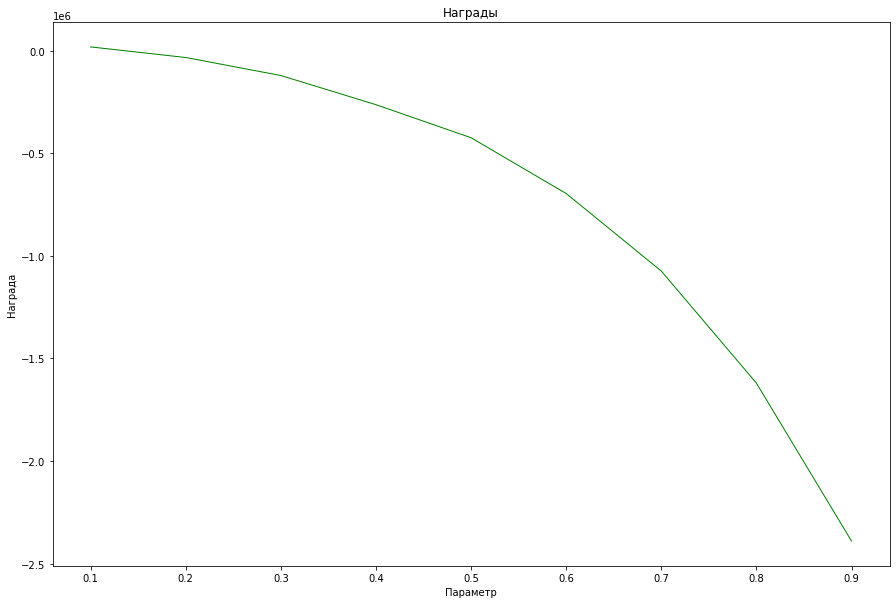

Best eps: 0.1


100%|██████████| 20000/20000 [01:40<00:00, 198.33it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


100%|██████████| 20000/20000 [00:13<00:00, 1528.69it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.38390613 -3.07175625 -3.44439998 -3.38211471  7.77793169 -3.78019199]
 [-0.84887542 -0.28867842 -1.80014555 -1.43167921 12.61556194 -1.68271401]
 ...
 [-0.96413731 -0.60015346 -0.97329573 -0.96372686 -1.46787015 -1.16898694]
 [-2.42371594 -2.4115813  -2.46628494 -1.76898812 -2.927902   -2.90000185]
 [-0.0591     -0.059982   -0.0591      4.36425339 -0.591      -0.591882  ]]


100%|██████████| 20000/20000 [00:10<00:00, 1969.06it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.20257554 -1.30554886 -3.5928591  -2.41690979  7.67063682 -5.02236739]
 [-0.64129406 -1.13347955  0.29161127 -1.55395502 12.27524517 -2.26712701]
 ...
 [-1.21017857 -1.18289389 -1.21869416  2.13724578 -1.167528   -2.32047111]
 [-2.81834001 -2.80288683 -2.84520349 -0.75521179 -4.54297517 -3.45465351]
 [-0.1164     -0.119928   -0.169416   10.5085566  -1.17084432 -1.167528  ]]


100%|██████████| 20000/20000 [00:09<00:00, 2164.51it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.47317017 -1.16681183 -2.18689342 -3.42545691  8.03726223 -4.51391845]
 [ 0.62851455  1.45843554 -1.57098989 -0.02692129 12.20665608 -4.23944219]
 ...
 [-1.36154384  1.7900738  -1.29686584 -1.33047847 -2.63147914 -3.10504001]
 [-3.02704394 -2.98125298 -3.03645536 -0.90231765 -3.23459533 -4.24918555]
 [-0.1719     -0.179838   -0.1719     13.20582749 -1.719      -1.726938  ]]


100%|██████████| 20000/20000 [00:08<00:00, 2261.06it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.73311138  1.43345456 -3.41755202 -0.6387658   7.95523804 -6.47451807]
 [ 1.89380031  4.20619914 -1.03960128  1.69515847 12.61945503 -3.82844679]
 ...
 [-1.2565618   5.57930013 -1.14130477 -1.12135271 -3.29270822 -2.270112  ]
 [-2.92494153 -2.80305306 -2.90233002 -1.34023898 -4.51631165 -3.46820801]
 [-0.2256     -0.239712   -0.2256     14.60073212 -4.36040288 -2.270112  ]]


100%|██████████| 20000/20000 [00:08<00:00, 2342.50it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.19760355  0.20434528 -3.00694341 -4.02317437  7.8903184  -5.78944093]
 [ 0.96018768  2.82410773  1.07696083  7.41768719 12.96597507 -0.38144908]
 ...
 [-1.53414676  4.77385179 -1.69192419 -1.60360133 -3.94806479 -4.08504018]
 [-3.99975645 -3.95646349 -3.73374368  1.53921001 -4.90184453 -6.76939251]
 [-0.53471737 -0.29955    -0.2775     17.40062009 -2.775      -4.0869675 ]]


100%|██████████| 20000/20000 [00:08<00:00, 2379.51it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.7253512  -1.38730579 -3.61603165  1.62021641  7.71909835 -7.22915427]
 [-1.15600383  1.80868588  1.45336227  6.00698745 13.1889222   0.3098183 ]
 ...
 [ 4.68191843 14.56522841  1.74780336  1.68604462 -0.12999745 -0.18908469]
 [-3.82648622 -3.71649691 -3.86017287  0.42255237 -4.83901882 -6.5788278 ]
 [-0.448632   -0.29907238 -0.3276     14.89091458  0.          0.        ]]


100%|██████████| 20000/20000 [00:08<00:00, 2347.04it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.78812774  4.16448537 -1.18849416 -1.61896252  7.56766004 -4.70766953]
 [-0.94827314  3.04378058  4.08978601  0.83658654 13.23343296 -2.53111537]
 ...
 [-1.90658756 -1.85819517 -1.96035527  5.11784419 -3.759      -3.802218  ]
 [-5.05810985 -4.89123412 -4.918578   -0.5191592  -6.73312685 -5.45585036]
 [-0.76489472 -0.65433006 -0.80808    17.05843333 -3.802218   -3.759     ]]


100%|██████████| 20000/20000 [00:08<00:00, 2435.71it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.42237696  4.30291468 -4.0635706   4.31694873  7.97853945 -4.8173097 ]
 [-1.14457057  3.67256574  2.36978246  7.52325156 12.98983753 -0.91606993]
 ...
 [-2.17943309 -2.1058904  -2.21486872  7.12933895 -5.90664883 -2.4       ]
 [-4.11854183 -3.86355005 -4.26624968  5.7091689  -6.32969142 -4.32334848]
 [-0.4224     -0.478848   -0.4224     17.44584087 -4.224      -4.280448  ]]


100%|██████████| 20000/20000 [00:08<00:00, 2446.98it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 1.30963124  2.9265053  -0.32528202  2.75130022  7.94715677 -5.04415133]
 [ 3.47548406 -1.10803922  2.55703413  4.85604078 13.06929032 -1.78422317]
 ...
 [ 4.21993499 14.56577103  4.83076365  2.37573484  1.82662244  2.36983045]
 [-4.18415942 -1.914448   -4.38440417 -4.41658709 -6.51172852 -4.79459466]
 [-0.4671     -0.538542   -0.4671     18.43188177 -4.671      -4.742442  ]]


100%|██████████| 20000/20000 [00:08<00:00, 2413.55it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.67634264  2.13716906 -1.7619858   4.57592529  8.25660087 -3.79658445]
 [ 4.27108655  5.79842818  8.02655195  6.07996718 13.2741716  -2.79780912]
 ...
 [-1.38658998  6.7899388  -2.5756192  -1.72446159 -5.1        -6.86898036]
 [-6.16028841  1.01251194 -6.24469087 -6.10358425 -8.08175307 -7.17877711]
 [-0.51       -0.5982     -0.51       18.25701107 -5.1        -5.1882    ]]


100%|██████████| 20000/20000 [00:08<00:00, 2473.67it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.33297367  3.72307992 -4.47489019 -0.28133965  6.73952868 -6.34385961]
 [ 0.77850144  5.34653184  9.02892181 -3.18450818 12.5001899  -6.79399732]
 ...
 [-2.22125937 14.37056056 -2.19336222 -1.97157319 -7.34764519 -0.92493233]
 [-3.00459743  6.77721654 -4.0004901  -2.68962271 -5.57815255 -5.84528441]
 [-0.87746274 -0.5511     -0.436722   17.90900844 -5.511      -5.617722  ]]


100%|██████████| 20000/20000 [00:07<00:00, 2508.89it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.12578849  3.61239248 -1.78884337  3.05468185  7.86114511 -3.44146084]
 [ 5.16290322  8.50492018  0.58508212  0.27729116 11.01446922  0.45672864]
 ...
 [ 9.26597484 14.46299536  7.15214148  8.74662786  3.41975273  3.02228778]
 [-4.78708635 -4.78720767 -5.13340008  7.29970095 -9.48369361 -8.72992512]
 [-0.5904     -0.5904     -0.487008   18.58830677 -5.904      -6.031008  ]]


100%|██████████| 20000/20000 [00:08<00:00, 2454.52it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.24728808   1.28189747  -1.90016317   4.45200178   8.12249638
   -7.78152362]
 [ -0.34207873   7.79454283   6.29954837   1.3295359   13.12741832
   -6.31515877]
 ...
 [  9.75657072  14.44708982  10.42316491   0.79734129   3.71728253
    0.31792611]
 [ -6.0689809   -6.11165062  -6.29817759  -6.23712593 -11.27189816
  -13.98667968]
 [ -0.86394438  -0.92334786   2.73716158  18.52130853  -6.279
   -6.428058  ]]


100%|██████████| 20000/20000 [00:08<00:00, 2386.88it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [  2.31964847   3.99048573   0.77461029   1.84577958   6.50000767
   -3.28790055]
 [  1.53741468   7.42398092   3.4062015    2.21362425  13.27445532
   -4.4144476 ]
 ...
 [ -3.95900887   2.13852413  -4.02889967  -3.90176213  -6.636
   -9.03000704]
 [ -7.84518332  -4.37867614  -5.85315782  -5.84643669  -6.808872
  -12.51724709]
 [ -0.804888    15.29296574  -0.6636      -0.6636      -4.7452372
   -6.808872  ]]


100%|██████████| 20000/20000 [00:08<00:00, 2411.28it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [  2.6226321    1.55710915  -0.9664316   -6.79401432   8.31006948
  -11.4408179 ]
 [  1.82139982   7.64473527   6.17441308   3.57336868  13.24320099
   -0.71765433]
 ...
 [ -2.818125     5.18947983  -2.1525115   -4.33946281  -9.02399617
   -7.17345   ]
 [ -7.07456005   7.67952458  -6.75256353  -6.92811802  -6.975
   -9.38175835]
 [ -0.6975      -0.64845     -0.6975      18.59558449  -6.975
   -7.17345   ]]


100%|██████████| 20000/20000 [00:08<00:00, 2437.43it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.47596059   2.421901     0.68318158   3.11709081   8.14365153
   -4.86214845]
 [  5.10245328   4.40341094   4.6092304    3.83670575  13.2744539
    1.87917458]
 ...
 [ -3.03610716   7.78047726  -2.89019749  -2.94463967  -7.296
   -7.521792  ]
 [ -8.19008772   4.29909492  -5.25504992  -5.63172158 -14.54069073
  -12.07724065]
 [ -1.44855368  -1.20259584  -1.20259584  18.6         -7.296
   -4.82899636]]


100%|██████████| 20000/20000 [00:08<00:00, 2358.55it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.39405538  -1.15664103  -1.08988187   2.30664549   6.29114444
   -2.71572041]
 [  5.2557751    0.13162303   4.64240018   5.41293793  13.26976458
    2.42199236]
 ...
 [ -2.53831979  11.16211859  -2.18651215  -2.12949297  -9.20330802
   -7.853898  ]
 [ -6.53010444  -6.14628242  -5.92116953   1.54023016  -7.599
  -10.88779799]
 [ -0.882351    -1.13969802  -0.7599      18.46648331  -7.599
   -9.20330802]]


100%|██████████| 20000/20000 [00:08<00:00, 2371.13it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -0.94566598   3.14946596  -3.73916607   2.12070333   7.69753014
   -7.54480728]
 [ -1.42399767   3.89493707  -0.04574402   0.69234752  13.27412757
  -15.25402076]
 ...
 [ -2.38031611  -2.53949309  -5.8237459    9.07981941 -10.0053291
   -7.884     ]
 [-10.09706073 -12.80299067 -10.1933292    6.57825821 -11.23140332
  -12.91934164]
 [ -1.31988528  -1.074168    -1.31988528  18.59963174  -9.44386128
   -8.169768  ]]


100%|██████████| 20000/20000 [00:08<00:00, 2365.44it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.79140853  0.4278739  -0.95447828 -0.44385221  8.36234335 -5.1872647 ]
 [ 2.79466507  7.39226374 -1.68052567  0.88999444 13.22609837 -6.87249601]
 ...
 [-3.27694289 13.92552067 -3.45852831 -3.46108573 -2.30340224 -3.13985529]
 [-5.80800855 -6.05491982 -5.26630145 -1.14766662 -8.151      -8.469402  ]
 [-0.8151     12.43954539 -0.8151     -0.8151     -8.469402   -8.469402  ]]


100%|██████████| 20000/20000 [00:08<00:00, 2283.44it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.99596569  -4.73167398  -3.99875143  -4.42525721   7.90308675
   -7.22148828]
 [  6.00671373   1.78365372   5.24496653  -1.66652506  13.21532878
   -4.59059223]
 ...
 [ -3.5486259    5.81436684  -3.65850651   2.28190126  -8.4
   -0.9375198 ]
 [ -9.20484854  -0.53744325  -8.87707013  -8.7934177  -13.7053057
   -8.89392   ]
 [ -0.84         7.73094629  -1.2888      18.59675361  -8.4
   -6.49392   ]]


100%|██████████| 20000/20000 [00:08<00:00, 2305.72it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.15368328  -6.73175665  -3.78730323   1.77844371   8.28278372
  -14.17029012]
 [  3.40324436   8.78263639   2.11454474  -2.06950956  12.58100946
    1.35284064]
 ...
 [ -5.38287469  -7.14067295  -5.20792027   7.55029793  -8.631
  -11.85576987]
 [ -8.49096373   3.08350124 -10.64979074  -8.83020662 -12.12156999
  -15.47123793]
 [ -1.71130117  -1.018962    -1.71130117  18.59997655   1.87874924
   -9.019962  ]]


100%|██████████| 20000/20000 [00:09<00:00, 2159.66it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.15287864  -7.33426808  -0.68838294  -7.53650127   8.35774964
   -6.10374628]
 [  1.58153239  -5.0444519   -1.18884612  -5.07672271  13.16369418
   -0.53995842]
 ...
 [ -1.76693464  14.54879651   6.87666961  -3.44639405  -9.2738281
    0.55691806]
 [ -9.63561273 -10.61294808  -9.98973472   2.83012393 -15.37133127
  -15.06850273]
 [ -6.6809952   -1.68093339   9.90731072  18.6        -10.45510108
   -9.270888  ]]


100%|██████████| 20000/20000 [00:09<00:00, 2149.26it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -8.73030794   3.75043973 -14.56663874   1.51294356   8.3623425
   -8.14847829]
 [ -1.93976617   0.52188778  -2.36471323   0.24918036  13.24519555
   -0.75460175]
 ...
 [ -9.18418138  -7.9768555   -9.15642525  -2.756774   -14.27934453
  -10.83079893]
 [-11.18744248   8.45990567 -13.60860409  -2.67520036 -16.19873047
  -17.5455588 ]
 [ -0.9039       9.83727683  -0.9039      18.57879165   1.32235933
   -9.505578  ]]


100%|██████████| 20000/20000 [00:09<00:00, 2134.93it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-15.46247283 -15.59599919 -10.28951804 -10.52153047   6.08915585
  -17.8173618 ]
 [ -6.90927158  -6.68014294  -2.66216058  -7.36743927  13.27445578
  -10.28420618]
 ...
 [  1.03929939  12.00896609   0.98191411  -0.35654917  -9.724032
    2.86785648]
 [-11.66845411   0.41990393 -12.0008296  -11.5262806  -17.49440613
  -19.40346535]
 [ -0.9216       6.8534012   -0.9216      16.54524107   4.23417105
   -6.98738024]]


100%|██████████| 20000/20000 [00:09<00:00, 2029.11it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.17779125e+01 -1.15853831e+01 -9.33091702e+00 -6.23159068e+00
   8.24730183e+00 -1.21724043e+01]
 [ 7.01380084e+00  7.98746636e+00 -3.91038014e+00  7.76524131e+00
   1.32689891e+01 -2.25050002e-01]
 ...
 [-1.65339765e-02  1.04440934e+01 -5.16293352e+00 -8.70259906e+00
  -1.43928938e+00 -1.60550682e+01]
 [-1.41636003e+01  4.33762597e+00 -1.35859365e+01 -1.37894175e+01
  -1.97974509e+01 -1.99213981e+01]
 [-1.67343750e+00 -1.48875000e+00 -9.37500000e-01  1.86000000e+01
   3.82724995e+00  3.68943750e+00]]


100%|██████████| 20000/20000 [00:10<00:00, 1961.01it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-13.5344582  -13.74758001 -13.58226965 -13.4735573    8.36232994
  -13.86560668]
 [ -4.2252017    8.49237442  -5.83346864  -9.38492037  13.10950787
  -11.90320417]
 ...
 [-10.18126713  14.5657712  -10.33464442  -9.95843418 -18.91547183
   -8.70128186]
 [-17.87271096   4.92436955 -22.56955374 -18.13060829  -9.49053952
  -21.84721563]
 [ 13.81888759  -1.547832     0.26049655  18.6         -9.516
   -4.81234507]]


100%|██████████| 20000/20000 [00:10<00:00, 1905.12it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-19.40091228 -15.52068119 -19.36399879 -16.48569375   8.3612914
  -29.91807008]
 [ -5.71042331  -5.71672144  -6.21986984  -6.28696526  13.27391468
   -9.82008109]
 ...
 [-13.90021707  -4.95516593 -13.88240745 -13.87741198 -14.28106292
  -15.03012467]
 [-18.74511767 -16.22398345 -19.03371446 -22.42718533 -25.22312926
  -25.48146546]
 [ -1.90921794  -1.636119    -2.29744805  18.6          4.83326486
  -10.281978  ]]


100%|██████████| 20000/20000 [00:11<00:00, 1800.67it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-18.78509467 -18.66919045 -18.30764691 -18.37906845   8.31764083
  -23.71552583]
 [-13.7762813  -13.48518473  -9.77775864 -10.25926749  13.27445578
  -19.54304587]
 ...
 [-10.10537867 -14.4909605  -10.15130189 -10.37172733 -19.22674842
  -10.435488  ]
 [-23.23317202   5.17064836 -23.59069502 -23.28341727 -30.21016233
  -29.51456754]
 [ -0.9744       3.87333258   0.19321217  18.6        -10.650528
    7.75021471]]


100%|██████████| 20000/20000 [00:11<00:00, 1756.79it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-20.57951094 -20.97258987 -27.53132577 -20.64240758   8.35712001
  -25.29185973]
 [  3.11346062 -16.4028981  -16.3518134  -16.91497267  13.27430942
  -20.21431755]
 ...
 [-10.96828113 -11.09327372 -10.58464239   6.01855754 -20.06670979
  -17.14037877]
 [-21.94768364 -22.59229408 -21.83987482 -20.13232684 -25.04929862
  -28.79444128]
 [ 13.99041777 -10.6312504   -1.47240458  18.6        -15.11103498
    4.74582545]]


100%|██████████| 20000/20000 [00:12<00:00, 1600.12it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-28.07638622 -27.97792131 -28.08850281 -31.74719368   8.36234335
  -30.37749292]
 [-21.30351516 -13.88119968 -13.80836563   2.79325976  10.76878733
  -21.53596342]
 ...
 [-10.14536828  14.5657712  -11.58623042   5.87484686 -19.27650538
    2.36451417]
 [-24.44832746 -24.09116408 -24.23105525 -27.10302486 -24.6303078
  -38.18514656]
 [ -7.82887754  -8.42396983  -7.80626776  18.5974422  -10.77318
  -10.6938    ]]


100%|██████████| 20000/20000 [00:13<00:00, 1463.10it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-34.41094288 -28.1566356  -28.08217683 -27.90251694   8.36234335
  -29.57527203]
 [-28.21705787   8.98953092 -28.3337346  -28.5562724   13.27445564
  -28.67215705]
 ...
 [-20.62535855 -16.58148124 -16.56569458 -16.52030468 -21.58946901
  -22.51037142]
 [-32.14165871 -30.98973323 -32.21690283 -25.87622729 -35.34741528
  -33.97473056]
 [ 15.95145836  -1.28653911  17.13870667  18.6          6.26335089
  -10.38418326]]


100%|██████████| 20000/20000 [00:17<00:00, 1162.27it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-34.02990818 -38.0413542  -36.10149267 -38.13390885   6.04501634
  -35.45839374]
 [-41.57185407 -34.43415885 -37.26113483  10.19228254  13.27445578
  -34.07435837]
 ...
 [-26.98855116 -28.30504433 -27.06736146   8.5391018  -29.00849946
  -30.68724306]
 [-39.55425818 -45.36116802 -39.37757996 -39.61547746 -39.44388934
  -41.6717268 ]
 [ -1.93923072  13.3534621   -1.93923072  18.6         -2.66840471
    7.46775595]]


100%|██████████| 20000/20000 [00:23<00:00, 851.36it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-44.55884399 -44.57276441 -44.82476583   6.6302371    8.24054794
  -50.08219344]
 [-33.3340684  -37.45554057 -39.31667907 -39.29770513  13.27445578
  -39.4143339 ]
 ...
 [-22.60584728  14.22663988 -19.86341406 -26.79006131 -30.98830308
  -27.5255243 ]
 [-54.20094719   9.55341158 -48.78875879 -48.80431418 -52.39511076
  -57.12928565]
 [ -0.999999    -3.6482553   17.03601997  18.6         -9.999
    8.228     ]]
Best lr: 0.36


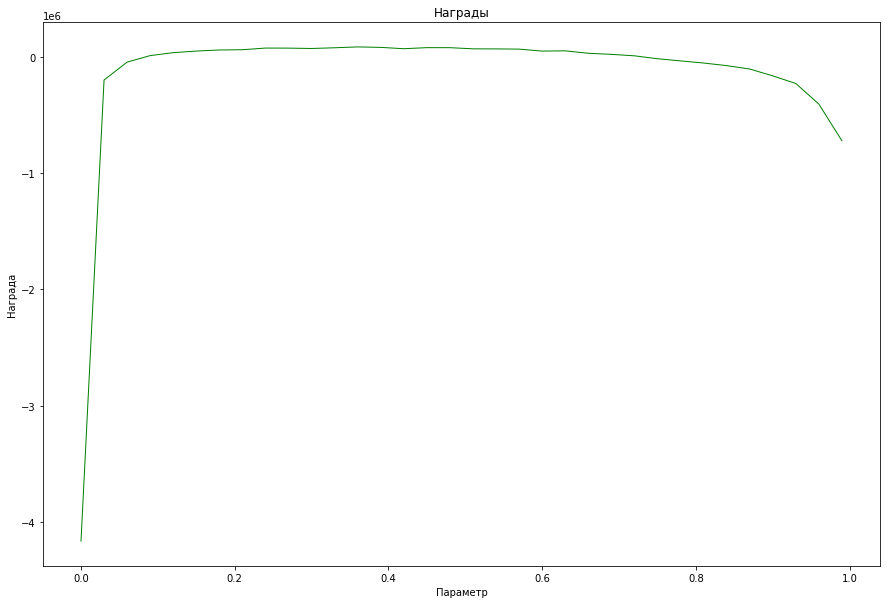

100%|██████████| 20000/20000 [01:36<00:00, 208.20it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.         -1.         -1.         -1.         -1.         -9.56019535]
 [-1.         -1.         -1.         -1.         -1.         -9.88470785]
 ...
 [-1.         -1.         -1.         -1.         -9.71852502 -8.92625818]
 [-1.         -1.         -1.         -1.         -9.81985601 -9.31280523]
 [-0.99527763 -0.99527763 -0.99697769 -0.99527763 -3.6        -5.904     ]]


100%|██████████| 20000/20000 [01:19<00:00, 251.70it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.03092784  -1.12813473  -1.07075303  -1.12813523  -1.09313914
  -10.0317954 ]
 [ -1.03511671  -1.12812364  -1.03714089  -1.09311737  -1.03092783
  -10.03049009]
 ...
 [ -1.12506751  -1.12502522  -1.12617725  -1.03119556  -9.91600819
   -9.98343135]
 [ -1.09313927  -1.12812297  -1.12811724  -1.03098109 -10.03083646
  -10.0283132 ]
 [ -0.737856    -0.82012675  -0.842727    -0.48441818  -7.4034432
   -7.38493632]]


100%|██████████| 20000/20000 [01:14<00:00, 268.39it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.25818443  -1.09645617  -1.08583765  -1.08477644  -1.06458518
  -10.06389963]
 [ -1.2580091   -1.1882788   -1.25828951  -1.25826659  -1.06381344
  -10.06668552]
 ...
 [ -1.18589673  -1.06789571  -1.25669588  -1.18826198 -10.02105388
   -9.95097981]
 [ -1.18826264  -1.25823867  -1.25825401  -1.06493084 -10.06476416
  -10.06188511]
 [ -0.85314217  -0.83579949  -0.85314217   0.2         -5.911776
   -5.89968   ]]


100%|██████████| 20000/20000 [01:13<00:00, 272.59it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.30565655  -1.28556004  -1.3906067   -1.39061673  -1.09890286
  -10.10231151]
 [ -1.09902439  -1.39064249  -1.28577696  -1.21845761  -1.21838437
  -10.10103203]
 ...
 [ -1.12641673  -1.24922494  -1.26258245  -1.10091544  -9.81365853
   -9.98149657]
 [ -1.21607569  -1.0990572   -1.28309518  -1.39053063  -9.81068916
  -10.02777332]
 [ -1.02972149  -0.77010961  -0.93627268   0.79968135  -8.88145546
   -5.92312896]]


100%|██████████| 20000/20000 [01:14<00:00, 268.59it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.31193403  -1.13636364  -1.20629077  -1.17855352  -1.29602537
  -10.14361304]
 [ -1.17815903  -1.38524414  -1.29608558  -1.29566383  -1.13637606
  -10.13861503]
 ...
 [ -1.37475294  -1.40857599  -1.51319931  -1.13636364  -9.86071858
   -9.97445311]
 [ -1.38328219  -1.14330356  -1.52371492  -1.52542951 -10.13634496
  -10.13037292]
 [ -0.8740565   -0.97732499  -0.87472835   1.39999998  -5.919552
   -5.919552  ]]


100%|██████████| 20000/20000 [01:12<00:00, 274.69it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.17694433  -1.30472828  -1.20994565  -1.4880372   -1.37609852
  -10.1834542 ]
 [ -1.1775155   -1.37566136  -1.4891979   -1.66281261  -1.30435029
  -10.18450372]
 ...
 [ -1.48795385  -1.1764708   -1.65820829  -1.6637057  -10.14033631
   -9.73472357]
 [ -1.66513147  -1.66457731  -1.66317504  -1.19327191 -10.18994755
  -10.19734072]
 [ -0.757296    -0.79570789  -0.60984      2.          -5.904
   -5.927328  ]]


100%|██████████| 20000/20000 [01:06<00:00, 301.68it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.2595806   -1.59584793  -1.60929804  -1.59341949  -1.80282852
  -10.25392559]
 [ -1.5938642   -1.45992295  -1.80148698  -1.80535906  -1.21550262
  -10.24871015]
 ...
 [ -1.77310558  -1.43001947  -1.27415774  -1.2195122  -10.10593562
   -9.92791118]
 [ -1.80460758  -1.21956557  -1.80551496  -1.59494208 -10.23497544
  -10.24453756]
 [ -0.89497083  -0.64358784  -0.89497083   2.59998806  -3.6
   -5.927328  ]]


100%|██████████| 20000/20000 [01:10<00:00, 282.55it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.44641631  -1.70131876  -1.43113928  -1.7019212   -1.26582422
  -10.27283655]
 [ -1.94261701  -1.54573736  -1.68051503  -1.54951842  -1.26550509
  -10.26744864]
 ...
 [ -1.8926874   -1.22448718  -1.35752922  -1.66888073  -9.80920029
   -9.9915237 ]
 [ -1.94736055  -1.70220837  -1.95216183  -1.27315414 -10.27472425
  -10.28243873]
 [ -0.5904      -0.90975097  -0.50852244   3.2         -7.93667727
   -8.10087046]]


100%|██████████| 20000/20000 [01:06<00:00, 301.30it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.1132843   -1.81549535  -1.53877009  -2.09692275  -1.31597692
  -10.35400066]
 [ -1.63693227  -2.09568783  -2.41076648  -1.31578947  -2.09321642
  -10.37502353]
 ...
 [ -1.41951852  -1.71192597  -1.74814091  -1.32134557  -7.48608199
   -9.83199453]
 [ -1.80429286  -2.05419968  -2.07130116  -1.34357673 -10.26017184
  -10.22449189]
 [ -0.5904      -0.621504    -0.54337697   3.63366823  -5.904
   -5.935104  ]]


100%|██████████| 20000/20000 [01:01<00:00, 327.53it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.90037515  -1.60020271  -1.75172522  -1.72936452  -1.37310213
  -10.4093927 ]
 [ -1.73937054  -1.93154834  -2.24063512  -1.59766375  -1.38100047
  -10.44124886]
 ...
 [ -1.61785277  -1.61716488  -1.86021141  -1.42436292 -10.17310974
   -9.93171369]
 [ -1.92402403  -1.37357367  -1.59305156  -1.97213189 -10.34367925
  -10.3544909 ]
 [ -0.5904      -1.16524138  -0.33392307   4.4         -6.95088
   -5.938992  ]]


100%|██████████| 20000/20000 [01:07<00:00, 296.54it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.7541384   -1.69294297  -2.39879496  -2.40228282  -1.42847117
  -10.45056337]
 [ -2.39434382  -2.0448975   -2.03145652  -2.42022012  -1.37873317
  -10.53209441]
 ...
 [ -1.62311612  -1.25828017  -2.00230731  -2.39205451 -10.24153571
   -7.63100122]
 [ -1.82929897  -2.40289524  -1.82980069  -1.43636988 -10.54112524
  -10.48684285]
 [ -0.55556499  -0.84871873  -0.22243757   5.          -6.84135698
   -5.94288   ]]


100%|██████████| 20000/20000 [01:10<00:00, 282.13it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.17395773  -1.78414361  -2.57724572  -2.5631175   -1.49253697
  -10.52024068]
 [ -1.77404841  -1.95897087  -2.19380185  -1.55243547  -1.42868371
  -10.56980111]
 ...
 [ -2.63674371  -1.23765281  -2.53995605  -2.56013373 -10.47483294
  -10.41963428]
 [ -2.22715177  -1.49251832  -2.58132597  -2.56630011 -10.56964033
  -10.57541213]
 [ -0.5904      -0.633168    -0.5904       4.99976103  -5.946768
   -5.87252275]]


100%|██████████| 20000/20000 [01:06<00:00, 301.58it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.57456844  -2.33325241  -2.30927375  -2.31176233  -2.05218781
  -10.64709531]
 [ -2.72611847  -2.41216124  -2.74572733  -2.31314844  -1.54793808
  -10.68194371]
 ...
 [ -1.84149041  -1.21578515  -1.54171574  -1.54649569  -5.98051584
   -9.73112472]
 [ -2.48288628  -2.58975202  -2.24541645  -1.64824674 -10.38931474
   -9.79831711]
 [ -0.5904      -0.637056    -0.5904       2.83354675  -5.904
   -5.950656  ]]


100%|██████████| 20000/20000 [01:03<00:00, 315.26it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.17163333  -2.90601905  -1.98540228  -2.91343741  -1.63989387
  -10.7028944 ]
 [ -2.87130845  -2.47175716  -2.13544853  -2.91358933  -1.45009707
  -10.73283006]
 ...
 [ -2.17982114  -1.13873956  -2.63631645  -1.63934426  -9.84853405
   -9.29827293]
 [ -2.69330254  -2.7230808   -1.95507759  -1.66294948  -9.75097431
  -10.24798249]
 [ -0.5904      -0.640944    -0.5904       2.7171072   -5.904
   -5.954544  ]]


100%|██████████| 20000/20000 [00:56<00:00, 352.87it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.08404466  -2.64384812  -3.11295689  -3.15734387  -1.7268028
  -10.93967809]
 [ -1.85574971  -3.0950354   -1.8036461   -3.12380461  -1.44978386
  -10.77004416]
 ...
 [ -2.76399005  -1.82260474  -2.30688222  -2.96861877  -9.43205534
   -8.7114256 ]
 [ -2.59913718  -1.72079801  -2.60626847  -3.10941333 -10.80565524
  -10.71796362]
 [ -0.5904      -0.644832    -0.5904       6.24207682  -3.6
   -5.958432  ]]


100%|██████████| 20000/20000 [00:57<00:00, 348.13it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.28349025  -2.06793766  -3.35018212  -2.08819485  -1.80376338
  -10.85952862]
 [ -3.2696424   -2.05348749  -2.72249404  -2.20782602  -1.41726186
  -10.71658377]
 ...
 [ -2.20228614  -2.53950393  -2.06203944  -1.81817452 -10.41450902
  -10.21802124]
 [ -2.76606528  -3.26852819  -3.28949819  -1.96969875 -10.95319527
  -10.97599697]
 [  0.53556796  -0.67750274   0.36864262   7.9440692   -6.11783506
   -6.22447581]]


100%|██████████| 20000/20000 [00:53<00:00, 370.62it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.93086912  -2.85325568  -2.22144645  -2.93201078  -1.92315476
  -10.95736408]
 [ -2.92673916  -3.47649189  -2.43812323  -2.82454465  -1.3702009
  -10.96217692]
 ...
 [ -1.9284821   -0.95782182  -2.01520102  -1.87803701  -7.60821504
   -8.52582298]
 [ -3.44206605  -1.92066522  -3.4708237   -3.4850779  -11.05509405
  -10.69971861]
 [ -0.5904      -0.652608    -0.5904       8.25052064  -7.7766912
   -5.966208  ]]


100%|██████████| 20000/20000 [00:54<00:00, 368.79it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.49739763  -3.12543888  -3.78441847  -2.32289897  -2.027475
  -11.09546207]
 [ -3.27074701  -3.34906819  -2.73033952  -1.97622605  -1.28547109
  -10.94980247]
 ...
 [ -2.43833937  -0.54971246  -2.22773374  -2.61148273  -9.42048614
   -7.79507145]
 [ -3.13809603  -3.08363469  -3.01892356  -2.05615247 -10.9910367
  -11.06205858]
 [ -0.5904      -0.656496    -0.5904       7.20182015  -5.904
   -5.970096  ]]


100%|██████████| 20000/20000 [00:57<00:00, 347.67it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.26731768  -2.47519341  -2.31383913  -2.39241821  -2.1230941
  -11.18684909]
 [ -2.4971134   -3.19352835  -3.81891904  -3.92093135  -1.71727704
  -11.2152434 ]
 ...
 [ -2.08039761  -0.31465188  -2.02412651  -2.06047574  -7.4624461
   -8.44291244]
 [ -3.2679676   -3.73052453  -3.91942673  -2.21678212 -11.20869195
  -11.26091253]
 [ -1.02045681  -0.660384    -1.16049169   9.72944192  -5.904
   -5.973984  ]]


100%|██████████| 20000/20000 [00:46<00:00, 433.13it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.27251335  -4.23915125  -3.61438664  -4.21924301  -2.39427086
  -11.6242835 ]
 [ -2.81593394  -4.00725     -2.38356695  -2.46786862  -0.98385217
  -10.81072401]
 ...
 [ -2.22473601   0.02286345  -2.20031569  -2.20923903  -8.34571793
   -7.62343067]
 [ -4.19017259  -2.08350548  -3.531936    -4.29152025 -11.59107447
  -11.29205121]
 [ -1.03091397  -0.71155008  -1.03091397   7.42691626  -5.904
   -7.54698816]]


100%|██████████| 20000/20000 [00:45<00:00, 437.26it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.52672476  -3.32097653  -4.47060858  -3.75914704  -3.33899355
  -11.70917107]
 [ -3.49249889  -2.38672193  -2.5         -3.86064598  -0.75716074
  -10.48347077]
 ...
 [ -2.14145436   0.41515822  -1.2059601   -1.82104512  -8.29534912
   -8.46513886]
 [ -2.52553125  -2.12711332  -4.49877129  -3.89382468 -11.7869768
  -11.84177193]
 [ -0.5904      -0.66816     -0.5904      10.716637    -5.904
   -5.98176   ]]


100%|██████████| 20000/20000 [00:42<00:00, 475.59it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.77318656  -3.63942329  -2.9938038   -4.76979122  -2.34783846
  -11.82890124]
 [ -3.21618152  -1.8773253   -3.29297824  -3.27325669  -0.44960353
  -10.30410164]
 ...
 [ -2.0768832   -1.85110076  -2.97067066  -2.08041225  -8.85205256
   -7.8775305 ]
 [ -4.03655297  -2.14561614  -3.15337633  -4.06229906 -11.84435315
  -11.22029055]
 [ -0.5904      -0.5904      -0.737856    11.36312714  -3.6
   -5.985648  ]]


100%|██████████| 20000/20000 [00:40<00:00, 497.37it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -5.09120748  -5.51818201  -3.99024143  -2.9640427   -2.44306339
  -12.216459  ]
 [ -3.14533954  -2.08598241  -2.71576846  -2.06382926  -0.1112738
   -9.07804865]
 ...
 [ -1.99958314  -0.37037067  -2.51846305  -2.0413027   -8.17721947
   -5.989536  ]
 [ -4.67229666  -2.25048844  -3.02414369  -4.35333803  -8.03709868
  -10.84437553]
 [ -0.823392    -0.5904      -0.5904      10.91889303  -7.3401207
   -6.94201163]]


100%|██████████| 20000/20000 [00:34<00:00, 574.16it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.62366515  -3.47746351  -3.9242379   -3.98759878  -2.41858128
  -12.31894029]
 [ -2.37962601  -2.44994496  -2.34269562  -2.46675042   0.27598138
  -10.24722993]
 ...
 [ -1.17916427   2.03877902  -2.64568284  -2.02902333  -6.87359372
   -8.35785988]
 [ -4.82588937  -4.12494566  -4.34683564  -3.37069048 -10.71283756
  -12.05792177]
 [ -1.0869589   -0.679824    -0.90672428  11.87588581  -5.993424
   -3.6       ]]


100%|██████████| 20000/20000 [00:28<00:00, 697.34it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -5.89755092  -5.83243224  -5.50722799  -5.74082681  -2.66990312
  -12.48117902]
 [ -2.44911704  -1.32805228  -1.70736165  -1.31413118   0.95527877
   -9.01394997]
 ...
 [ -2.64808871  -2.60811335  -2.68614568  -1.73538364  -3.6
   -5.997312  ]
 [ -5.61299503  -3.38840175  -5.61299503  -4.66373312 -12.13785092
  -10.80266189]
 [ -0.89088768  -0.74343168  -0.5904      13.2738956   -5.904
   -5.12624896]]


100%|██████████| 20000/20000 [00:24<00:00, 803.24it/s] 


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.05586252  -5.1727817   -4.20927282  -6.00378984  -2.30867162
  -11.98979702]
 [ -1.76188128  -1.83256039  -2.24135425  -1.76199802   1.56348133
   -8.56766473]
 ...
 [ -1.90079651   2.60253774  -1.92481279  -1.97453261  -5.904
   -6.0012    ]
 [ -2.95916027  -1.63869609  -2.75134865  -2.96334313  -8.8290664
  -10.45653379]
 [ -1.09365696  -0.6876      -1.09365696  12.75986084  -5.904
   -6.0012    ]]


100%|██████████| 20000/20000 [00:17<00:00, 1129.03it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.79500992  -3.63596024  -5.11885756  -3.07574067  -2.16373958
  -11.26520454]
 [ -1.10995081  -1.04436083  -2.67322175  -1.2035113    2.42509699
   -8.69523497]
 ...
 [ -2.8989109    4.42002615   0.77494533  -0.95165341  -8.95733022
   -6.005088  ]
 [ -3.20666384  -1.24742822  -3.82129058  -4.13741209  -9.59724354
   -8.89386291]
 [ -0.5904       0.23229756  -0.5904      14.22933574  -5.904
   -6.005088  ]]


100%|██████████| 20000/20000 [00:15<00:00, 1295.02it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.08943641  -3.54516299  -4.30954976  -4.17241752  -1.74127204
  -11.250808  ]
 [ -3.05055826   0.37060996  -0.86241165   1.11763594   1.77488465
   -7.0629607 ]
 ...
 [ -2.63293956  -2.70303788  -2.88786484   1.33252579  -7.95064849
   -6.008976  ]
 [ -4.41224915  -2.44857209  -3.93354895  -3.86786053  -8.4081034
  -10.52202457]
 [ -0.5904      -0.94062764  -0.5904      15.02060516  -5.904
   -6.008976  ]]


100%|██████████| 20000/20000 [00:10<00:00, 1878.95it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.26627877  -2.26103156  -4.46941463  -3.43522291  -0.81409113
  -10.85029685]
 [ -1.10461592   0.70047739  -0.26685591   1.26031033   3.34514062
   -7.85245462]
 ...
 [ -2.50045455  -2.15132282  -2.15144778   0.87733813  -5.904
   -6.012864  ]
 [ -4.30298677  -4.27389659  -4.21646959  -0.86926816  -5.904
   -6.012864  ]
 [  5.35993291   2.89755628  -2.5232256   15.79947015  -3.7305933
   -2.67031296]]


100%|██████████| 20000/20000 [00:09<00:00, 2139.75it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -5.11915489  -3.43921506  -3.43973335  -3.40319495  -0.9096724
  -10.33568818]
 [ -1.7572038   -2.69269286  -1.61729105   0.95190266   6.06003328
   -5.5643777 ]
 ...
 [  0.60108389   8.1725492    0.08569026  -0.77276479  -6.68497474
   -6.51601744]
 [ -2.53545612   1.38411426  -1.49882802  -4.18986233  -8.63383789
   -8.97514457]
 [  4.05796142   4.70507128  -0.5904      16.39999989  -0.76752
   -3.78491328]]


100%|██████████| 20000/20000 [00:08<00:00, 2367.40it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.84666626  -2.98495159  -2.73259728  -2.60622958   1.51763926
  -10.1846855 ]
 [  0.12643626  -0.18072871   0.96313942  -0.17547419   7.65788167
   -5.26781204]
 ...
 [ -3.10253111  -2.87674706  -2.80595712   1.030577    -5.904
   -6.02064   ]
 [ -3.54218161   0.40148474  -3.43233011  -3.36388444  -5.904
   -6.02064   ]
 [ -0.737856    -0.70704     -0.5904      16.98111201  -6.0952896
   -6.02064   ]]


100%|██████████| 20000/20000 [00:08<00:00, 2425.13it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.85120552  -0.6679109   -2.97444151  -7.73916064   2.75101574
   -9.39693686]
 [  3.16532403   1.4490294   -1.09884982  -0.36824317   9.48990258
   -6.59559851]
 ...
 [ -1.71251836   7.85503239  -1.73950255  -1.91124736  -5.904
   -6.024528  ]
 [ -6.04687552  -6.75468244  -6.29875213   2.33649237 -11.67954631
  -11.68300962]
 [ 11.12493771   4.86197118   8.26784909  17.6          1.34138687
   -1.61862736]]


100%|██████████| 20000/20000 [00:08<00:00, 2457.31it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.64319819  0.65938217 -2.26559493 -0.35964353  6.11911771 -8.05341952]
 [-0.29852873  2.16326894  7.87970259  7.49581859 11.68588538 -4.07191608]
 ...
 [-2.15925015 -1.82113772 -2.02966339  5.49875725 -3.6        -6.028416  ]
 [-5.32900045  1.5284973  -5.50772897 -5.24403732 -6.028416   -9.43145174]
 [ 5.552064   -0.714816   -0.5904     18.2        -5.904      -6.028416  ]]


100%|██████████| 20000/20000 [00:08<00:00, 2468.24it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.50412175  2.1662417  -4.39895317  2.14176385  8.31165748 -6.15668895]
 [ 6.31735944  7.27020981  7.62208565  6.47184878 13.9191195   0.55253165]
 ...
 [-3.15290027  9.51919001 -2.63951598 -2.40183662 -7.68026903 -6.032304  ]
 [-6.56709838 -6.13971273 -6.39052882  4.77509271 -9.5066137  -8.47913549]
 [-1.17731428 -0.88293312 -1.17731428 18.76018034 -5.904      -6.032304  ]]
Best gamma: 0.96


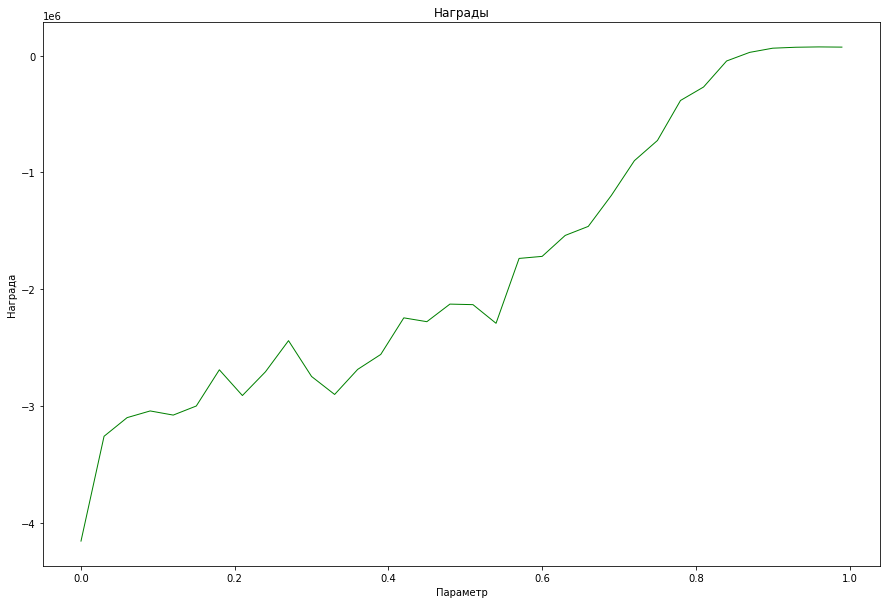

[18264, -33370, -121144, -263298, -424450, -696310, -1074274, -1620491, -2390381]
[-4160173, -201355, -47865, 8177, 33521, 47011, 56353, 58657, 72861, 72359, 69286, 75398, 82775, 78733, 67271, 76465, 76188, 66296, 65648, 63878, 46827, 49095, 28110, 18846, 6307, -18710, -37237, -55485, -77938, -106897, -165854, -231122, -407845, -722718]
[-4158519, -3260836, -3101045, -3043747, -3079244, -3001532, -2691425, -2911742, -2708420, -2441768, -2748571, -2902610, -2687828, -2559897, -2246482, -2279213, -2128724, -2133386, -2293065, -1737466, -1719802, -1540392, -1463129, -1198205, -900240, -727233, -384578, -269316, -46266, 27454, 63259, 71349, 74252, 72454]
Best params: eps=0.1, lr=0.36, gamma=0.96


In [15]:
find_hyperparameters_sarsa()

100%|██████████| 20000/20000 [00:08<00:00, 2492.88it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.16382105  2.12457359  1.55626889  2.43397146  5.43916403 -7.22022915]
 [-0.7491885   6.8605947   5.36373432  5.84926792 11.57875384 -0.35616984]
 ...
 [-3.1232704  11.23181581 -1.71449363 -2.82347681 -5.904      -3.80404224]
 [-5.76334008 -5.79946919 -5.69197124  2.28337198 -5.904      -9.11015189]
 [-1.16685711  2.28282964  9.24712402 18.2         0.38592    -1.16826624]]


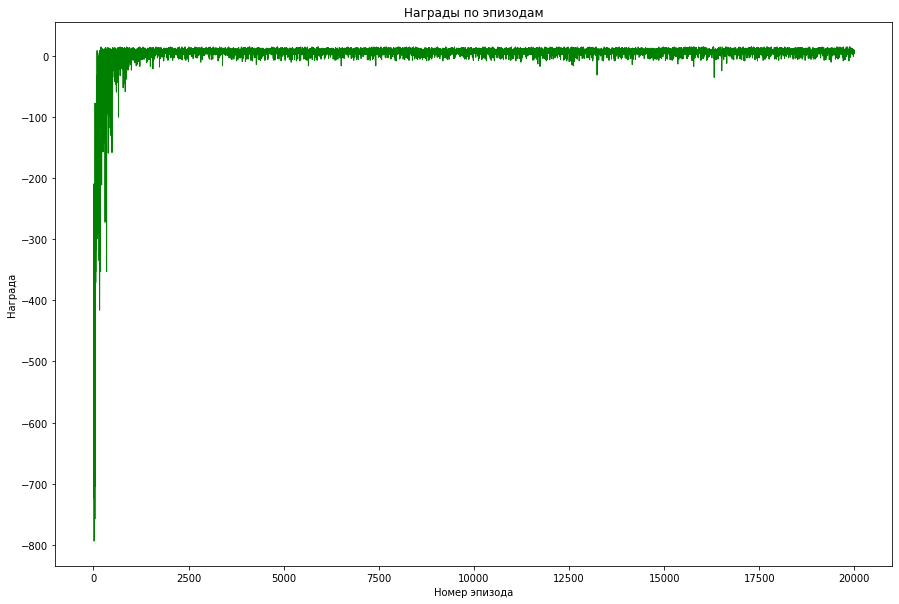

In [16]:
run_sarsa(eps=0.1, lr=0.36, gamma=0.96)